In [ ]:
import os
os.chdir('..')

# Importación de librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from joblib import Parallel, delayed
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
import pickle

c:\Users\dylan\.conda\envs\LDI3\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
from scripts import *

In [3]:
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style='whitegrid', palette='muted', font_scale=1.1)
sns.set_context("notebook", rc={"figure.figsize": (12, 6)})

# Carga de datasets

In [4]:
path_products = './datasets/tb_productos.txt'
path_stocks = './datasets/tb_stocks.txt'
path_sells = './datasets/sell-in.txt'
path_products_to_predict = './datasets/product_id_apredecir201912.txt'

full_dataset_path = './datasets/full_dataset.parquet'
transformed_dataset_path = './datasets/transformed_dataset.parquet'

train_test_path = './datasets/train_test.parquet'

In [5]:
tn_scaler_path='./scalers/scalers.pkl'
encoders_path='./encoders/encoders.pkl'
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size']

In [6]:
#path_products = 'https://drive.usercontent.google.com/u/0/uc?id=1s-AqqbU8AkCquQSTabKQcSyTWJxfzWdC&export=download'
#path_stocks = 'https://drive.usercontent.google.com/u/0/uc?id=1hWem2eGQuxKvRLYowsEr7kEeBLqJMh9y&export=download'
#path_sells = 'https://drive.usercontent.google.com/download?id=1a51g5fWTolz8ffJzqOraoFBbpMrDxDSo&export=download&authuser=0&confirm=t&uuid=7b59490c-94b4-4e15-9493-2679ad9211b6&at=ALoNOgm-5Vr0oaK-fRAcN97ldtSW%3A1748109329167'

In [7]:
df_products = pd.read_csv(path_products, sep='\t', dtype={ 'product_id': str, 'sku_size': str })
df_stocks = pd.read_csv(path_stocks, sep='\t', dtype={ 'product_id': str, 'periodo': str })
df_sell_in = pd.read_csv(path_sells, sep='\t', dtype={ 'product_id': str, 'customer_id': str, 'periodo': str })
df_products_to_predict = pd.read_csv(path_products_to_predict, dtype={ 'product_id': str })

# Feature Engineering

## Lectura de datasets

In [8]:
df_products

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288
...,...,...,...,...,...,...
1257,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,12,20240
1258,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,6,20285
1259,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,2,20259
1260,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,12,20142


In [9]:
df_stocks

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595
...,...,...,...
13686,201912,20453,1.43741
13687,201912,21026,7.26817
13688,201912,21054,0.50833
13689,201912,20981,2.18491


In [10]:
df_sell_in

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452
...,...,...,...,...,...,...,...
2945813,201912,10105,20853,0,1,0.02230,0.02230
2945814,201912,10092,20853,0,1,0.00669,0.00669
2945815,201912,10006,20853,0,7,0.02898,0.02898
2945816,201912,10018,20853,0,4,0.01561,0.01561


In [11]:
df_products_to_predict

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005
...,...
775,21263
776,21265
777,21266
778,21267


In [12]:
df_sell_in[df_sell_in['customer_id'] == '10309']

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
1650805,201808,10309,20479,0,1,0.40295,0.40295
1650834,201808,10309,20313,0,1,0.88452,0.88452
1729777,201808,10309,20191,0,1,1.20120,1.20120
1729848,201808,10309,20164,0,1,1.20120,1.20120
1729861,201808,10309,20203,0,1,0.21840,0.21840
...,...,...,...,...,...,...,...
2941445,201912,10309,20515,0,1,3.36118,3.36118
2941564,201912,10309,20792,0,1,1.68059,1.68059
2941572,201912,10309,20854,0,1,0.81081,0.81081
2942145,201912,10309,20992,0,1,2.54300,2.54300


In [13]:
df_sell_in[df_sell_in['product_id'] == '20524']

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452
...,...,...,...,...,...,...,...
2887928,201912,10012,20524,0,2,0.54513,0.54513
2887929,201912,10018,20524,0,4,0.03786,0.03786
2887930,201912,10035,20524,0,1,0.03786,0.03786
2887931,201912,10001,20524,0,3,0.14385,0.14385


## Unificación del dataset

Un producto empieza a existir en el periodo que tiene la primera venta para algun cliente deja de existir en el periodo que tiene la ultima venta para algun cliente

In [14]:
df_sell_in['periodo'] = pd.to_datetime(df_sell_in['periodo'].astype(str), format='%Y%m')

In [15]:
df_sell_in[(df_sell_in['customer_id'] == '10312') & (df_sell_in['product_id'] == '20524')]

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
693808,2017-09-01,10312,20524,0,1,0.01514,0.01514
1131265,2018-02-01,10312,20524,0,1,0.02271,0.02271
1215253,2018-03-01,10312,20524,0,1,0.01514,0.01514
1573333,2018-07-01,10312,20524,0,1,0.02271,0.02271
1812795,2018-10-01,10312,20524,0,1,0.02271,0.02271
1965194,2018-12-01,10312,20524,0,1,0.02271,0.02271
2426279,2019-06-01,10312,20524,0,1,0.01514,0.01514


In [16]:
product_life = df_sell_in.groupby('product_id')['periodo'].agg(['min', 'max']).rename(columns={
    'min': 'start_p',
    'max': 'end_p'
})

product_life

,start_p,end_p
product_id,,
20001,2017-01-01,2019-12-01
20002,2017-01-01,2019-12-01
20003,2017-01-01,2019-12-01
20004,2017-01-01,2019-12-01
20005,2017-01-01,2019-12-01
...,...,...
21295,2017-01-01,2017-01-01
21296,2017-08-01,2017-08-01
21297,2017-01-01,2017-01-01


In [17]:
product_life.loc['20524']

start_p   2017-01-01
end_p     2019-12-01
Name: 20524, dtype: datetime64[ns]

In [18]:
customer_life = df_sell_in.groupby('customer_id')['periodo'].agg(['min', 'max']).rename(columns={
    'min': 'start_c',
    'max': 'end_c'
})

customer_life

,start_c,end_c
customer_id,,
10001,2017-01-01,2019-12-01
10002,2017-01-01,2019-12-01
10003,2017-01-01,2019-12-01
10004,2017-01-01,2019-12-01
10005,2017-01-01,2019-12-01
...,...,...
10633,2017-01-01,2017-01-01
10634,2017-02-01,2017-02-01
10635,2017-01-01,2017-03-01


In [19]:
customer_life.loc['10309']

start_c   2018-08-01
end_c     2019-12-01
Name: 10309, dtype: datetime64[ns]

In [20]:
all_periods = pd.date_range(df_sell_in['periodo'].min(), df_sell_in['periodo'].max(), freq='MS')
all_periods

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [21]:
len(all_periods) * len(df_sell_in['customer_id'].unique()) * len(df_sell_in['product_id'].unique())

26499636

In [22]:
clientes = df_sell_in['customer_id'].unique()
productos = df_sell_in['product_id'].unique()

index = pd.MultiIndex.from_product(
    [clientes, productos, all_periods],
    names=['customer_id', 'product_id', 'periodo']
)

all_combinations = index.to_frame(index=False)
all_combinations

,customer_id,product_id,periodo
0,10234,20524,2017-01-01
1,10234,20524,2017-02-01
2,10234,20524,2017-03-01
3,10234,20524,2017-04-01
4,10234,20524,2017-05-01
...,...,...,...
26499631,10572,20770,2019-08-01
26499632,10572,20770,2019-09-01
26499633,10572,20770,2019-10-01
26499634,10572,20770,2019-11-01


In [23]:
df_all_combinations = all_combinations.merge(product_life, on='product_id').merge(customer_life, on='customer_id')
df_all_combinations

,customer_id,product_id,periodo,start_p,end_p,start_c,end_c
0,10234,20524,2017-01-01,2017-01-01,2019-12-01,2017-01-01,2019-12-01
1,10234,20524,2017-02-01,2017-01-01,2019-12-01,2017-01-01,2019-12-01
2,10234,20524,2017-03-01,2017-01-01,2019-12-01,2017-01-01,2019-12-01
3,10234,20524,2017-04-01,2017-01-01,2019-12-01,2017-01-01,2019-12-01
4,10234,20524,2017-05-01,2017-01-01,2019-12-01,2017-01-01,2019-12-01
...,...,...,...,...,...,...,...
26499631,10572,20770,2019-08-01,2019-12-01,2019-12-01,2019-12-01,2019-12-01
26499632,10572,20770,2019-09-01,2019-12-01,2019-12-01,2019-12-01,2019-12-01
26499633,10572,20770,2019-10-01,2019-12-01,2019-12-01,2019-12-01,2019-12-01
26499634,10572,20770,2019-11-01,2019-12-01,2019-12-01,2019-12-01,2019-12-01


In [24]:
#df_complete = df_all_combinations[
#    (df_all_combinations['periodo'] >= df_all_combinations[['start_p', 'start_c']].min(axis=1)) & 
#    (df_all_combinations['periodo'] <= df_all_combinations[['end_p', 'end_c']].max(axis=1))
#]

df_complete = df_all_combinations[
    (df_all_combinations['periodo'] >= df_all_combinations['start_p']) & 
    (df_all_combinations['periodo'] <= df_all_combinations['end_p']) &
    (df_all_combinations['periodo'] >= df_all_combinations['start_c']) &
    (df_all_combinations['periodo'] <= df_all_combinations['end_c'])
]

df_complete = df_complete.drop(columns=['start_p', 'end_p', 'start_c', 'end_c'])

df_complete

,customer_id,product_id,periodo
0,10234,20524,2017-01-01
1,10234,20524,2017-02-01
2,10234,20524,2017-03-01
3,10234,20524,2017-04-01
4,10234,20524,2017-05-01
...,...,...,...
26499491,10572,21054,2019-12-01
26499527,10572,20728,2019-12-01
26499563,10572,20792,2019-12-01
26499599,10572,20854,2019-12-01


In [25]:
df_sell_in_complete = pd.merge(
    df_complete,
    df_sell_in,
    on=['customer_id', 'product_id', 'periodo'],
    how='left'
)

df_sell_in_complete

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,10234,20524,2017-01-01,0.0,2.0,0.05300,0.05300
1,10234,20524,2017-02-01,NaN,NaN,NaN,NaN
2,10234,20524,2017-03-01,0.0,1.0,0.01514,0.01514
3,10234,20524,2017-04-01,NaN,NaN,NaN,NaN
4,10234,20524,2017-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15563108,10572,21054,2019-12-01,NaN,NaN,NaN,NaN
15563109,10572,20728,2019-12-01,NaN,NaN,NaN,NaN
15563110,10572,20792,2019-12-01,NaN,NaN,NaN,NaN
15563111,10572,20854,2019-12-01,NaN,NaN,NaN,NaN


In [26]:
df_sell_in_complete['periodo'] = df_sell_in_complete['periodo'].dt.strftime('%Y%m')
df_sell_in_complete

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,10234,20524,201701,0.0,2.0,0.05300,0.05300
1,10234,20524,201702,NaN,NaN,NaN,NaN
2,10234,20524,201703,0.0,1.0,0.01514,0.01514
3,10234,20524,201704,NaN,NaN,NaN,NaN
4,10234,20524,201705,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15563108,10572,21054,201912,NaN,NaN,NaN,NaN
15563109,10572,20728,201912,NaN,NaN,NaN,NaN
15563110,10572,20792,201912,NaN,NaN,NaN,NaN
15563111,10572,20854,201912,NaN,NaN,NaN,NaN


In [27]:
df = df_sell_in_complete.merge(df_products, on='product_id').merge(df_stocks, on=['periodo', 'product_id'], how='left')
df

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
0,10234,20524,201701,0.0,2.0,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500,NaN
1,10234,20524,201702,NaN,NaN,NaN,NaN,HC,VAJILLA,Cristalino,Importado,500,NaN
2,10234,20524,201703,0.0,1.0,0.01514,0.01514,HC,VAJILLA,Cristalino,Importado,500,NaN
3,10234,20524,201704,NaN,NaN,NaN,NaN,HC,VAJILLA,Cristalino,Importado,500,NaN
4,10234,20524,201705,NaN,NaN,NaN,NaN,HC,VAJILLA,Cristalino,Importado,500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15601217,10572,21054,201912,NaN,NaN,NaN,NaN,PC,CABELLO,Shampoo Bebe,NIVEA,400,0.50833
15601218,10572,20728,201912,NaN,NaN,NaN,NaN,FOODS,ADEREZOS,Ketchup,NATURA,250,40.76709
15601219,10572,20792,201912,NaN,NaN,NaN,NaN,HC,PROFESIONAL,LV ROPA LIQUIDO,INDUSTRIAL,5000,44.77833
15601220,10572,20854,201912,NaN,NaN,NaN,NaN,HC,PROFESIONAL,SUAVIZANTE,INDUSTRIAL,5000,45.92788


In [28]:
df.drop(columns=['plan_precios_cuidados', 'stock_final', 'cust_request_qty'], inplace=True)

In [29]:
df.drop(columns=['cust_request_tn'], inplace=True)
df

,customer_id,product_id,periodo,tn,cat1,cat2,cat3,brand,sku_size
0,10234,20524,201701,0.05300,HC,VAJILLA,Cristalino,Importado,500
1,10234,20524,201702,NaN,HC,VAJILLA,Cristalino,Importado,500
2,10234,20524,201703,0.01514,HC,VAJILLA,Cristalino,Importado,500
3,10234,20524,201704,NaN,HC,VAJILLA,Cristalino,Importado,500
4,10234,20524,201705,NaN,HC,VAJILLA,Cristalino,Importado,500
...,...,...,...,...,...,...,...,...,...
15601217,10572,21054,201912,NaN,PC,CABELLO,Shampoo Bebe,NIVEA,400
15601218,10572,20728,201912,NaN,FOODS,ADEREZOS,Ketchup,NATURA,250
15601219,10572,20792,201912,NaN,HC,PROFESIONAL,LV ROPA LIQUIDO,INDUSTRIAL,5000
15601220,10572,20854,201912,NaN,HC,PROFESIONAL,SUAVIZANTE,INDUSTRIAL,5000


## Creo features

In [30]:
df = create_periodo_dt(df)

In [31]:
df = create_date_features(df)

In [32]:
df['no_sale'] = ((df['tn'] == 0)).astype(int)

In [33]:
df['meses_sin_ventas'] = (df.groupby(['product_id','customer_id'])['no_sale'].apply(meses_sin_ventas).reset_index(level=[0,1], drop=True))

In [34]:
df = fill_tn_with_0(df)

In [35]:
df = df.sort_values(['customer_id', 'product_id', 'periodo'])

In [36]:
g = df.groupby(['customer_id', 'product_id'])['tn']

s = g.shift(1)

df['w_rank'] = s.rolling(12, min_periods=1).mean()

In [37]:
last_month = df['periodo_dt'].max()

last_tn = (
    df[df['periodo_dt'] == last_month]
    .groupby(['customer_id', 'product_id'])['tn']
    .sum()
    .clip(lower=0)
      .rename('w_tn')
)

df = df.merge(last_tn, on=['customer_id', 'product_id'], how='left')
df['w_tn'] = df['w_tn'].fillna(0)

In [38]:
features = [
    #'w_volumen', 
    #'w_estabilidad', 
    #'w_frecuencia', 
    'w_rank', 
    'w_tn'
]
scaler = MinMaxScaler(feature_range=(0, 1))
df[features] = scaler.fit_transform(df[features])

In [39]:
#df[features] = df[features].fillna(0)

In [40]:
#df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn', 'w_volumen', 'w_frecuencia', 'w_estabilidad', 'w_rank', 'w_tn']]

In [ ]:
df_train = df[~df['periodo'].isin(['201912', '201911'])]
df_train = scale_tn(df_train, tn_scaler_path, is_train=True)
df_train[['customer_id', 'product_id', 'periodo', 'tn']]

,customer_id,product_id,periodo,tn
0,10001,20001,201701,5.038570
1,10001,20001,201702,10.222084
2,10001,20001,201703,4.674948
3,10001,20001,201704,0.546698
4,10001,20001,201705,5.120283
...,...,...,...,...
15601217,10637,21255,201709,-0.053810
15601218,10637,21257,201709,-0.051244
15601219,10637,21260,201709,-0.071148
15601220,10637,21264,201709,-0.060151


In [43]:
df_train[(df['product_id'] == '20001')][['periodo', 'tn']].describe()

C:\Users\dylan\AppData\Local\Temp\ipykernel_2316\1543041884.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train[(df['product_id'] == '20001')][['periodo', 'tn']].describe()


,tn
count,1.686300e+04
mean,-6.741792e-18
std,1.000030e+00
min,-1.466933e-01
25%,-1.466933e-01
50%,-1.466933e-01
75%,-1.402680e-01
max,2.433335e+01


In [44]:
df = scale_tn(df, tn_scaler_path, is_train=False)

⚠️ Warning: No scaler found for product 20728, assigning 0s
⚠️ Warning: No scaler found for product 20770, assigning 0s
⚠️ Warning: No scaler found for product 20792, assigning 0s
⚠️ Warning: No scaler found for product 20854, assigning 0s


In [45]:
df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn']]

,periodo,tn
0,201701,5.038570
1,201702,10.222084
2,201703,4.674948
3,201704,0.546698
4,201705,5.120283
5,201706,6.530414
6,201707,5.130789
7,201708,2.113251
8,201709,14.941584
9,201710,11.435519


In [46]:
df = set_categorical_features(df)

In [47]:
#df['mean_tn_product'] = df.groupby(['product_id'])['tn'].transform('mean')
#df['std_tn_product'] = df.groupby(['product_id'])['tn'].transform('std')
#df['mean_tn_customer'] = df.groupby(['customer_id'])['tn'].transform('mean')
#df['std_tn_customer'] = df.groupby(['customer_id'])['tn'].transform('std')

In [48]:
#df['ratio_tn_customer_vs_product'] = df['mean_tn_customer'] / df['mean_tn_product']
#df['rank_producto_por_cliente'] = df.groupby('customer_id')['tn'].transform(lambda x: x.rank(method='dense', ascending=False))
#df['share_producto_en_mes'] = df.groupby(['customer_id', 'periodo'])['tn'].transform(lambda x: x / x.sum())#
#df['share_producto_en_mes'] = df['share_producto_en_mes'].fillna(0)
#df['frecuencia_ventas'] = df.groupby(['customer_id', 'product_id'])['tn'].transform(lambda x: (x > 0).sum() / len(x))

In [49]:
#df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn', 'mean_tn_product', 'std_tn_product', 'mean_tn_product', 'std_tn_customer', 'ratio_tn_customer_vs_product', 'rank_producto_por_cliente','share_producto_en_mes', 'share_producto_en_mes', 'frecuencia_ventas']]

In [50]:
df['customer_id'] = df['customer_id'].astype('category')
df['product_id'] = df['product_id'].astype('category')

In [51]:
delta_lag_features = create_delta_lag_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt']])

In [52]:
for col in delta_lag_features.columns:
    df[col] = delta_lag_features[col]

In [53]:
del delta_lag_features

In [ ]:
lag_features = create_lag_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt']])

In [ ]:
for col in lag_features.columns:
    df[col] = lag_features[col]

In [ ]:
del lag_features

In [ ]:
ma_features = create_ma_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt']])

In [ ]:
for col in ma_features.columns:
    df[col] = ma_features[col]

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3472745050.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = ma_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3472745050.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = ma_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3472745050.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [ ]:
del ma_features

In [ ]:
delta_ma_features = create_delta_ma_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt', 'tn_ma_2', 'tn_ma_3', 'tn_ma_4', 'tn_ma_5', 'tn_ma_6', 'tn_ma_7', 'tn_ma_8', 'tn_ma_9', 'tn_ma_10', 'tn_ma_11', 'tn_ma_12', 'tn_ma_13', 'tn_ma_14', 'tn_ma_15', 'tn_ma_16', 'tn_ma_17', 'tn_ma_18', 'tn_ma_19', 'tn_ma_20', 'tn_ma_21', 'tn_ma_22', 'tn_ma_23', 'tn_ma_24', 'tn_ma_25', 'tn_ma_26', 'tn_ma_27', 'tn_ma_28', 'tn_ma_29', 'tn_ma_30', 'tn_ma_31', 'tn_ma_32', 'tn_ma_33', 'tn_ma_34', 'tn_ma_35', 'tn_ma_36']])

In [ ]:
for col in delta_ma_features.columns:
    df[col] = delta_ma_features[col]

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3834236016.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = delta_ma_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3834236016.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = delta_ma_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3834236016.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [ ]:
del delta_ma_features

In [ ]:
std_features = create_std_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt']])

In [ ]:
for col in std_features.columns:
    df[col] = std_features[col]

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\2978732253.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = std_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\2978732253.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = std_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\2978732253.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [ ]:
del std_features

In [ ]:
df['mes_conflictivo'] = ((df['periodo'] == '201908') | (df['periodo'] == '201906'))

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3283713886.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['mes_conflictivo'] = ((df['periodo'] == '201908') | (df['periodo'] == '201906'))


In [ ]:
min_features = create_min_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt']])

In [ ]:
for col in min_features.columns:
    df[col] = min_features[col]

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\4244692887.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = min_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\4244692887.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = min_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\4244692887.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [ ]:
del min_features

In [ ]:
max_features = create_max_features(df[['customer_id', 'product_id', 'tn', 'periodo_dt']])

In [ ]:
for col in max_features.columns:
    df[col] = max_features[col]

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\183724535.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = max_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\183724535.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = max_features[col]
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\183724535.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [ ]:
del max_features

In [ ]:
df['customer_id'] = df['customer_id'].astype(str)
df['product_id'] = df['product_id'].astype(str)

In [ ]:
df = limit_categorical_values(df,  columns=['customer_id', 'product_id'])

c:\Users\dylan\Desktop\labo3-2025v\scripts.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_limited"] = np.where(df[col].isin(top_values), df[col], other_value)
c:\Users\dylan\Desktop\labo3-2025v\scripts.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_limited"] = np.where(df[col].isin(top_values), df[col], other_value)


In [ ]:
#df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn', 'customer_id_limited', 'product_id_limited', 'customer_id_limited_encoded', 'product_id_limited_encoded']]

In [ ]:
df['customer_id_limited'] = df['customer_id_limited'].astype(str)
df['product_id_limited'] = df['product_id_limited'].astype(str)

In [ ]:
df = set_ordinal_features(df, ['customer_id_limited', 'product_id_limited'], is_train=True)

[Train] (1/2) Encoding 'customer_id_limited'


c:\Users\dylan\Desktop\labo3-2025v\scripts.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}{suffix}"] = oe.fit_transform(df[[col]]).astype("int32")


[Train] (2/2) Encoding 'product_id_limited'


c:\Users\dylan\Desktop\labo3-2025v\scripts.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}{suffix}"] = oe.fit_transform(df[[col]]).astype("int32")


In [ ]:
df['customer_id'] = df['customer_id'].astype('category')
df['product_id'] = df['product_id'].astype('category')

In [ ]:
df['customer_id_limited_encoded'] = df['customer_id_limited_encoded'].astype('category')
df['product_id_limited_encoded'] = df['product_id_limited_encoded'].astype('category')

In [ ]:
bool_cols = df.select_dtypes(include=['bool']).columns

In [ ]:
for col in bool_cols:
    df[col] = df[col].astype(int)

In [ ]:
df['target'] = df.groupby(['customer_id', 'product_id'])['tn'].transform(lambda x: x.shift(-2))

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\531598088.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['target'] = df.groupby(['customer_id', 'product_id'])['tn'].transform(lambda x: x.shift(-2))
C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\531598088.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = df.groupby(['customer_id', 'product_id'])['tn'].transform(lambda x: x.shift(-2))


In [ ]:
df = reduce_mem_usage(df)

In [ ]:
df.to_parquet(full_dataset_path, index=False)

In [ ]:
del df

In [ ]:
df = pd.read_parquet(full_dataset_path)

In [ ]:
lr_params = df.groupby(['customer_id', 'product_id'])['tn'].apply(get_linear_regression_params).unstack()

C:\Users\dylan\AppData\Local\Temp\ipykernel_4764\3167975606.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lr_params = df.groupby(['customer_id', 'product_id'])['tn'].apply(get_linear_regression_params).unstack()


In [ ]:
df['lr_slope'] = df.set_index(['customer_id', 'product_id']).index.map(lr_params['slope'])

In [ ]:
df['lr_intercept'] = df.set_index(['customer_id', 'product_id']).index.map(lr_params['intercept'])

In [ ]:
df['r_squared'] = df.set_index(['customer_id', 'product_id']).index.map(lr_params['r_squared'])

In [ ]:
df[['lr_slope', 'lr_intercept', 'r_squared']] = df[['lr_slope', 'lr_intercept', 'r_squared']].fillna(0)

In [ ]:
df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn', 'lr_slope', 'lr_intercept', 'r_squared']]

,periodo,tn,lr_slope,lr_intercept,r_squared
0,201701,5.038570,0.179702,5.903437,0.117251
1,201702,10.222084,0.179702,5.903437,0.117251
2,201703,4.674948,0.179702,5.903437,0.117251
3,201704,0.546698,0.179702,5.903437,0.117251
4,201705,5.120283,0.179702,5.903437,0.117251
5,201706,6.530414,0.179702,5.903437,0.117251
6,201707,5.130789,0.179702,5.903437,0.117251
7,201708,2.113251,0.179702,5.903437,0.117251
8,201709,14.941584,0.179702,5.903437,0.117251
9,201710,11.435519,0.179702,5.903437,0.117251


In [ ]:
df.to_parquet(full_dataset_path, index=False)

In [ ]:
del df

In [ ]:
df = pd.read_parquet(full_dataset_path)

In [ ]:
# Filtrar para customer_id 20001 y product_id 10001
df_subset = df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn', 'lr_slope', 'lr_intercept']]
df_subset

,periodo,tn,lr_slope,lr_intercept
0,201701,5.038570,0.179702,5.903437
1,201702,10.222084,0.179702,5.903437
2,201703,4.674948,0.179702,5.903437
3,201704,0.546698,0.179702,5.903437
4,201705,5.120283,0.179702,5.903437
5,201706,6.530414,0.179702,5.903437
6,201707,5.130789,0.179702,5.903437
7,201708,2.113251,0.179702,5.903437
8,201709,14.941584,0.179702,5.903437
9,201710,11.435519,0.179702,5.903437


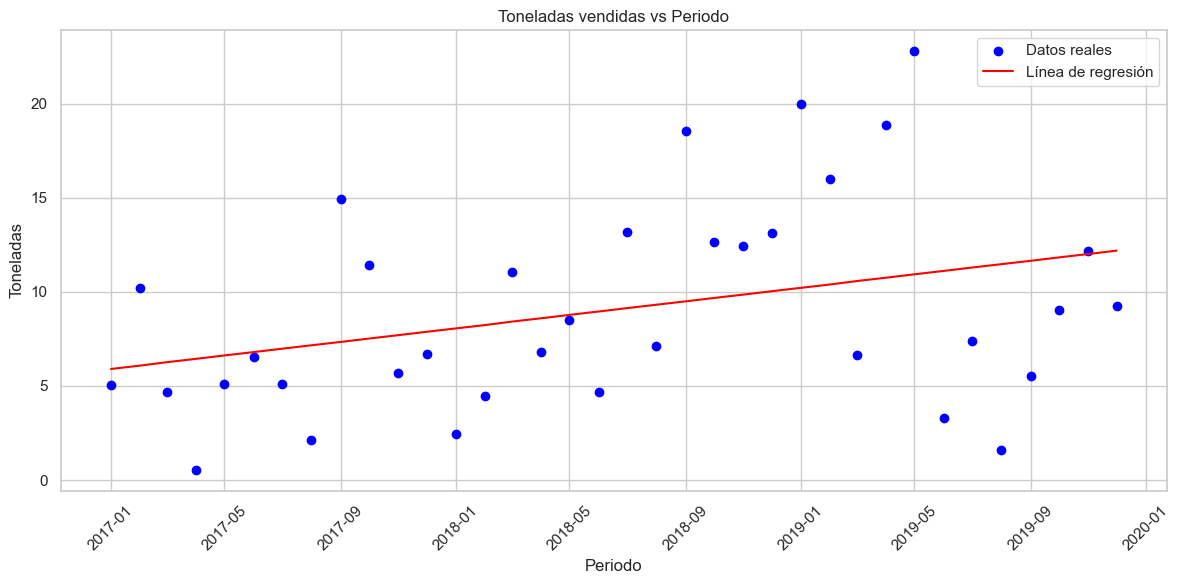

In [ ]:
# Importar matplotlib para graficar
import matplotlib.pyplot as plt

# Convertir periodo a datetime para mejor visualización
df_subset['periodo'] = pd.to_datetime(df_subset['periodo'].astype(str), format='%Y%m')

# Crear el gráfico
plt.figure(figsize=(12,6))

# Graficar los puntos de datos reales
plt.scatter(df_subset['periodo'], df_subset['tn'], color='blue', label='Datos reales')

# Calcular y graficar la línea de regresión
x = range(len(df_subset))
y = df_subset['lr_slope'].iloc[0] * x + df_subset['lr_intercept'].iloc[0]
plt.plot(df_subset['periodo'], y, color='red', label='Línea de regresión')

plt.title('Toneladas vendidas vs Periodo')
plt.xlabel('Periodo')
plt.ylabel('Toneladas')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#df = pd.read_parquet(full_dataset_path)

In [ ]:
#loess_features = df.groupby(['customer_id', 'product_id'])['tn'].apply(apply_loess_smoothing).unstack()

#df['loess_smoothed'] = df.set_index(['customer_id', 'product_id']).index.map(loess_features['loess_smoothed'])
#df['detrended_loess'] = df.set_index(['customer_id', 'product_id']).index.map(loess_features['detrended_loess']) 
#df['future_trend'] = df.set_index(['customer_id', 'product_id']).index.map(loess_features['future_trend'])
#df[['loess_smoothed', 'detrended_loess', 'future_trend']] = df[['loess_smoothed', 'detrended_loess', 'future_trend']].fillna(0)

In [ ]:
#df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')][['periodo', 'tn', 'loess_smoothed', 'detrended_loess', 'future_trend']]

In [ ]:
#df = reduce_mem_usage(df)

In [ ]:
#df.to_parquet(full_dataset_path, index=False)